# What are the top 10 suburbs with the highest predicted growth rate?

code reference:<br>

pre-process with data:<br>
https://github.com/alexkruczkowski/Rental-Rates-Analysis/blob/master/.ipynb_checkpoints/RentalRatesV1-checkpoint.ipynb <br>

fit time series regression model:<br>
https://ishan-mehta17.medium.com/simple-linear-regression-fit-and-prediction-on-time-series-data-with-visualization-in-python-41a77baf104c

In [1]:
import pandas as pd
import numpy as np

## Download past years median rental data and preprocessing

Data Reference: https://www.dhhs.vic.gov.au/past-rental-reports

In [2]:
# Read xlsx file into DataFrame df
xls = pd.ExcelFile('../data/external-raw-data/Quarterly median rents by local government area - March Quarter 2021.xlsx')
# set header
df = pd.read_excel(xls, 'All Properties', header=[2,3])

# Read xlsx file into DataFrame df
xls_convert = pd.ExcelFile('../data/external-raw-data/lga_postcode_table.xlsx')
df_convert = pd.read_excel(xls_convert, 'lga_postcode_mappings')

In [3]:
# Preprocessing for rent data file
# Change the Local Government Area column of rent data to UPPER case for merge
df.loc[:, ('Unnamed: 1_level_0', 'Unnamed: 1_level_1')] = df['Unnamed: 1_level_0']['Unnamed: 1_level_1'].str.upper()
# drop first column which is the region column that we do not need
df = df.drop([('Unnamed: 0_level_0', 'Unnamed: 0_level_1')], axis=1)

In [4]:
# convert multi index to simple index
df.columns = df.columns.map('_'.join)
df.rename(columns = {'Unnamed: 1_level_0_Unnamed: 1_level_1':'LGA region'}, inplace = True)
df

,LGA region,Jun 1999_Count,Jun 1999_Median,Sep 1999_Count,Sep 1999_Median,Dec 1999_Count,Dec 1999_Median,Mar 2000_Count,Mar 2000_Median,Jun 2000_Count,...,Mar 2020_Count,Mar 2020_Median,Jun 2020_Count,Jun 2020_Median,Sep 2020_Count,Sep 2020_Median,Dec 2020_Count,Dec 2020_Median,Mar 2021_Count,Mar 2021_Median
0,COLAC-OTWAY,100.0,114.0,78.0,115.0,81.0,115.0,97.0,115.0,91.0,...,131.0,320.0,87.0,320.0,130.0,335.0,112.0,328.0,86.0,335.0
1,CORANGAMITE,35.0,90.0,45.0,90.0,47.0,100.0,50.0,100.0,40.0,...,63.0,300.0,57.0,270.0,76.0,280.0,52.0,290.0,56.0,315.0
2,GLENELG,124.0,110.0,119.0,100.0,120.0,100.0,141.0,105.0,129.0,...,93.0,300.0,98.0,290.0,88.0,300.0,75.0,320.0,83.0,330.0
3,GREATER GEELONG,1371.0,135.0,1326.0,135.0,1406.0,140.0,1510.0,140.0,1316.0,...,2208.0,380.0,1811.0,370.0,2063.0,375.0,1970.0,380.0,1809.0,400.0
4,MOYNE,43.0,130.0,38.0,120.0,45.0,120.0,58.0,120.0,42.0,...,53.0,360.0,50.0,300.0,45.0,320.0,41.0,370.0,45.0,350.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,VICTORIA,31033.0,160.0,32385.0,160.0,32254.0,165.0,38248.0,170.0,31387.0,...,62720.0,410.0,47088.0,390.0,48411.0,390.0,55017.0,390.0,61313.0,390.0
88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,METRO,22849.0,170.0,24284.0,175.0,24027.0,180.0,28442.0,180.0,23581.0,...,52044.0,425.0,37673.0,400.0,38604.0,400.0,46084.0,400.0,52811.0,395.0
90,NON-METRO,8184.0,125.0,8101.0,130.0,8227.0,130.0,9806.0,130.0,7806.0,...,10676.0,335.0,9415.0,330.0,9807.0,340.0,8933.0,350.0,8502.0,350.0


In [5]:
# Only remain the data of Victoria
df_convert = df_convert[df_convert['State'] =='Victoria']
df_convert = df_convert[df_convert['Postcode']< 4000]
df_convert = df_convert[df_convert['Postcode']>= 3000]

# Change the LGA region column of convertion file to UPPER case for merge
df_convert['LGA region'] = df_convert['LGA region'].str.upper().str.strip()

In [6]:
# reset the index and drop the original index column
df_convert = df_convert.reset_index()
df_convert = df_convert.drop(['index'], axis=1)
df_convert

,State,LGA region,Postcode
0,Victoria,ALPINE,3678
1,Victoria,ALPINE,3691
2,Victoria,ALPINE,3695
3,Victoria,ALPINE,3697
4,Victoria,ALPINE,3698
...,...,...,...
1488,Victoria,YARRIAMBIACK,3490
1489,Victoria,YARRIAMBIACK,3491
1490,Victoria,YARRIAMBIACK,3507
1491,Victoria,YARRIAMBIACK,3531


In [7]:
# make sure LGA region for two dataframe are the same data type
df.loc[:,"LGA region"] = df.loc[:,"LGA region"].astype(str).str.strip()
df_convert.loc[:,"LGA region"] = df_convert.loc[:,"LGA region"].astype(str).str.strip()

# inner join merge by Local Government Area and LGA region
df_merge = df_convert.merge(df, left_on="LGA region", right_on="LGA region", how='inner')

In [8]:
# drop the state and lga region columns which we do not need it anymore
df_merge = df_merge.drop(['State', 'LGA region'], axis=1)

In [9]:
# check null value for merged dataframe
counts =df_merge.isna().sum()

# group by by postcode by median rent of each postcode
df_group_by = df_merge.groupby(['Postcode']).median()

# save as csv
df_group_by.to_csv("../data/raw/external-data/rent_by_postcode.csv")

Import the past years rental data

In [10]:
df = pd.read_csv("../data/raw/external-data/rent_by_postcode.csv")

In [11]:
# we try to get every year's March data to avoid seasonal impact, but some years do not record the median rent data of March
# so we assume there is no seasonal import for 2004, 2009, 2012 and 2013.
POSTCODE_COLS = ['Postcode']
TIME_COLS = ['Mar 2000_Median', 'Mar 2001_Median', 'Mar 2002_Median', 'Mar 2003_Median',
             'Sep 2004_Median', 'Mar 2005_Median', 'Mar 2006_Median', 'Mar 2007_Median',
             'Mar 2008_Median', 'Dec 2009_Median', 'Mar 2010_Median', 'Mar 2011_Median',
             'Dec 2012_Median', 'Dec 2013_Median', 'Mar 2014_Median', 'Mar 2015_Median',
             'Mar 2016_Median', 'Mar 2017_Median', 'Mar 2018_Median', 'Mar 2019_Median',
             'Mar 2020_Median', 'Mar 2021_Median']

In [12]:
df = df[POSTCODE_COLS + TIME_COLS]
# delect the 'median' in the column name so that we can convert those column names to DATE TYPE
df.rename(columns=lambda x: str(x[3:-7]), inplace=True)
# rename the postcode
df.columns.values[0] = "Postcode"

In [13]:
# Read model data to get the 2022 data
df_model_data = pd.read_csv("../data/curated/model-data/model-data.csv")
# Only remain the postcode and price columns
df_model_data = df_model_data[['postcode', 'price']]
# group by each postcode by median to make it consistence with previous years data
df_model_data = df_model_data.groupby(['postcode']).median()
# reset the index
df_model_data = df_model_data.reset_index()
# convert the postcode data type so that it can merge with past years median rent data
df_model_data['postcode'] = df_model_data['postcode'].astype(int)
df_model_data.head()

,postcode,price
0,3000,557.5
1,3002,625.0
2,3003,500.0
3,3004,600.0
4,3006,570.0


In [14]:
# merge the median rent data of 2022 and median rent data of past years 
df = df_model_data.merge(df, left_on='postcode', right_on='Postcode', how='inner').drop('Postcode', axis = 1)

In [15]:
# rename 2022 median rent data and change the column position
df.rename(columns={"price": "2022"}, inplace=True)
cols = df.columns.tolist()
cols.remove('2022')
cols.append('2022')
df = df[cols]

## Prediction

Since we only want to use 2000-2022 data which is certainly true data with reliability, we do not want to add prediction to df, it will let the prediction value participate in the model fitting, so we will make a copy of df which is called df_prediction.

In [16]:
# make a copy of df
df_prediction = df.copy(deep=True)

In [17]:
def rent_price_forecast(after_2022_year, forecast_year, df, df_prediction):
    # make a postcode list
    postcode_list = df['postcode'].tolist()
    # create a empty list to contain the prediction of 2023 median rent price
    rent_list = []
    for i in range(len(postcode_list)):
        # code ref: https://github.com/alexkruczkowski/Rental-Rates-Analysis/blob/master/.ipynb_checkpoints/RentalRatesV1-checkpoint.ipynb
        df_each_postcode = df[df['postcode'] == postcode_list[i]]
        # convert the column names to Date type
        df_test = df_each_postcode.melt(id_vars=["postcode"], 
                                        var_name="Date", value_name="Value")
        df_test['Date']= pd.to_datetime(df_test['Date'])
        # drop the postcode for each instance for fit model
        df_test2 = df_test.drop(['postcode'], axis = 1)
        df_test2.set_index('Date', inplace=True)
        df_test2 = df_test2.reset_index()
        df_test['Date']= pd.to_datetime(df_test['Date'])
        df_test2 = df_test.drop(['postcode'], axis = 1)
        df_test2.set_index('Date', inplace=True)
        df_test2 = df_test2.reset_index()
        x = np.arange(df_test2['Date'].size)
        fit = np.polyfit(x, df_test2['Value'], deg=1)
        # code ref: https://ishan-mehta17.medium.com/simple-linear-regression-fit-and-prediction-on-time-series-data-with-visualization-in-python-41a77baf104c
        # Fit function :[linear regression ]
        fit_function = np.poly1d(fit)
        rent_list.append(fit_function(df_test2['Date'].size + after_2022_year))
    df_prediction[forecast_year] = rent_list

In [18]:
rent_price_forecast(1, "2023", df, df_prediction)
rent_price_forecast(2, "2024", df, df_prediction)
rent_price_forecast(3, "2025", df, df_prediction)

In [19]:
# assign the df_prediction value to df
df = df_prediction

In [20]:
# calculate the growth rate between 2022-2025(3 years forecast)
df['3Yr-ROI']=(df['2025'] - df['2022'])/df['2022']

In [21]:
# decend sort the growth rate and reset the index
df = df.sort_values(by=['3Yr-ROI'], ascending=False).reset_index()
# get the postcode and growth rate column only
df_3Yr_ROI_rank = df[['postcode', '3Yr-ROI']]
df_3Yr_ROI_rank.head()

,postcode,3Yr-ROI
0,3085,0.921203
1,3194,0.393716
2,3175,0.354104
3,3047,0.302735
4,3028,0.298002


In [22]:
# save as csv
df_3Yr_ROI_rank.to_csv('../data/raw/external-data/3Yr_ROI_rank.csv')

## Visualization

Draw the multi lines plot for the 10 suburbs which have the highest rent growth rate

In [23]:
# only remain the top 10
df_plot = df.head(10).drop(["index","3Yr-ROI"], axis = 1)
# make postcode become index for ploting
df_plot.index = df_plot['postcode']

In [24]:
# Do the dataframe transpose for ploting
df_plot_T = df_plot.T
# Drop the first row
df_plot_T = df_plot_T.iloc[1:]
df_plot_T

postcode,3085,3194,3175,3047,3028,3171,3174,3019,3190,3191
2000,177.500000,220.000000,170.000000,170.000000,169.000000,170.000000,170.000000,155.000000,220.000000,270.000000
2001,185.000000,235.000000,177.500000,177.500000,175.000000,180.000000,177.500000,165.000000,235.000000,290.000000
2002,197.500000,245.000000,187.500000,185.000000,182.500000,195.000000,185.000000,175.000000,245.000000,295.000000
2003,202.500000,245.000000,192.500000,192.500000,187.500000,200.000000,190.000000,185.000000,245.000000,290.000000
2004,205.000000,251.500000,200.000000,200.000000,195.000000,205.000000,195.500000,190.000000,251.500000,298.000000
2005,215.000000,255.000000,205.000000,205.000000,200.000000,210.000000,202.500000,195.000000,255.000000,300.000000
2006,223.000000,279.000000,219.000000,215.000000,205.000000,225.000000,212.500000,210.000000,279.000000,333.000000
2007,240.000000,312.500000,240.000000,230.000000,225.000000,250.000000,232.500000,240.000000,312.500000,375.000000
2008,277.500000,360.500000,270.000000,260.000000,255.000000,281.000000,275.000000,270.000000,360.500000,440.000000
2009,310.000000,385.000000,310.000000,310.000000,290.000000,320.000000,317.500000,300.000000,385.000000,450.000000


<AxesSubplot:>

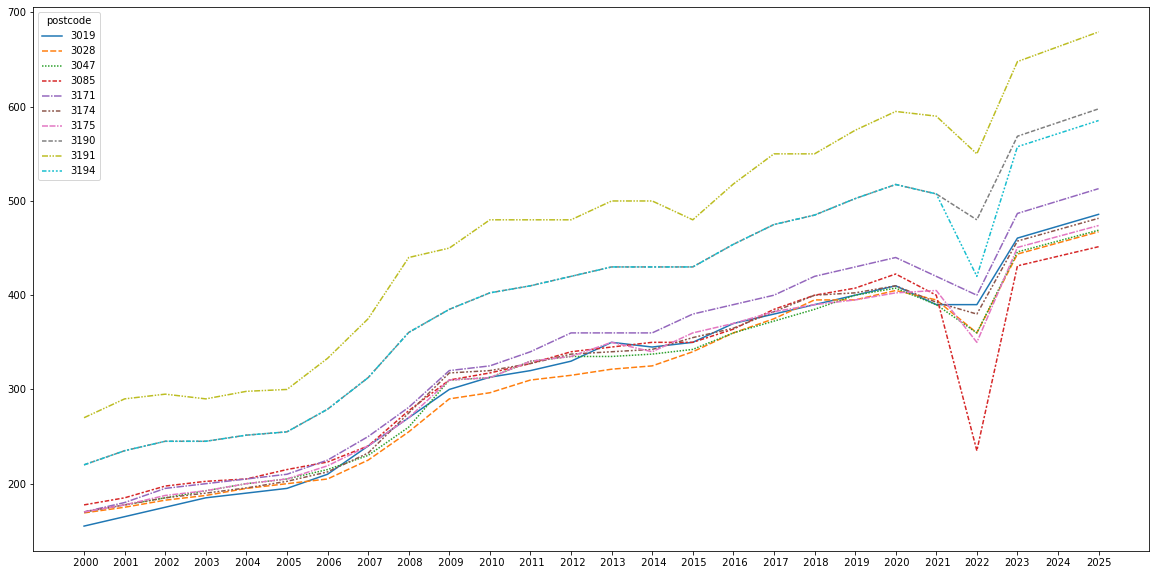

In [25]:
# Draw the line plot for these top 10 suburbs with the rent price data from 2000-2025(forecast:2023-2025)
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 10))  # generate a figure and return figure and axis handle
sns.lineplot(data=df_plot_T,ax=ax)


We actual fit time series regression for each postcode, the growth rate for 3085 is pretty high. We will show the visualization for postcode 3085 to see if this is reasonable

In [26]:
df = df.drop(['index','3Yr-ROI','2023','2024','2025'], axis = 1)

In [27]:
# visulization for postcode 3085 which have the highest rent growth rate
df_each_postcode = df[df['postcode'] == 3085]
df_test = df_each_postcode.melt(id_vars=["postcode"], 
                                    var_name="Date", value_name="Value")
df_test['Date']= pd.to_datetime(df_test['Date'])
df_test2 = df_test.drop(['postcode'], axis = 1)
df_test2.set_index('Date', inplace=True)
df_test2 = df_test2.reset_index()
df_test['Date']= pd.to_datetime(df_test['Date'])
df_test2 = df_test.drop(['postcode'], axis = 1)
df_test2.set_index('Date', inplace=True)
df_test2 = df_test2.reset_index()
x = np.arange(df_test2['Date'].size)
fit = np.polyfit(x, df_test2['Value'], deg=1)
# code ref:https://ishan-mehta17.medium.com/simple-linear-regression-fit-and-prediction-on-time-series-data-with-visualization-in-python-41a77baf104c
#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)


In [28]:
# code ref:https://ishan-mehta17.medium.com/simple-linear-regression-fit-and-prediction-on-time-series-data-with-visualization-in-python-41a77baf104c
# fit the model
fit = np.polyfit(x, df_test2['Value'], deg=1)
# print the slope and intercept
print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))

Slope : 10.165513833992094
Intercept : 187.17934782608694


In [29]:
df_test2

,Date,Value
0,2000-01-01,177.5
1,2001-01-01,185.0
2,2002-01-01,197.5
3,2003-01-01,202.5
4,2004-01-01,205.0
5,2005-01-01,215.0
6,2006-01-01,223.0
7,2007-01-01,240.0
8,2008-01-01,277.5
9,2009-01-01,310.0


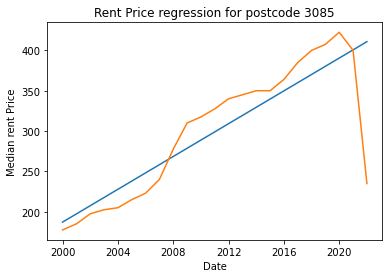

In [30]:
# code ref:https://ishan-mehta17.medium.com/simple-linear-regression-fit-and-prediction-on-time-series-data-with-visualization-in-python-41a77baf104c
#Fit function : y = mx + c [linear regression ]
fit_function = np.poly1d(fit)

#Linear regression plot
plt.plot(df_test2['Date'], fit_function(x))
#Time series data plot
plt.plot(df_test2['Date'], df_test2['Value'])

plt.xlabel('Date')
plt.ylabel('Median rent Price')
plt.title('Rent Price regression for postcode 3085')
plt.show()

In [31]:
prediction_3085 = fit_function(df_test2['Date'].size+3)
print(prediction_3085)

451.4827075098814


It is pretty reasonable since there is a big crash from 2020-2022. We 

suspect that the rent in this area has dropped very badly because of the pandemic. 

This suggests that housing prices in this area have been hit harder by the pandemic. When the epidemic slowly recedes, the rent in this area will naturally rebound, and may return to the price before the epidemic, so the growth rate may be high since the rent in 2022 is very low, this is reasonable.